# 1. Data

## 1.1 Imports

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve, plot_roc_curve

In [2]:
data = pd.read_csv("data/creditcard.csv")

## 1.2 EDA

In [3]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- **Time**: It is only a counter.
- **V1-V28**: Anonymized data.
- **Amount**: Transaction amount.
- **Class**: Fraud = 1, Normal = 0.

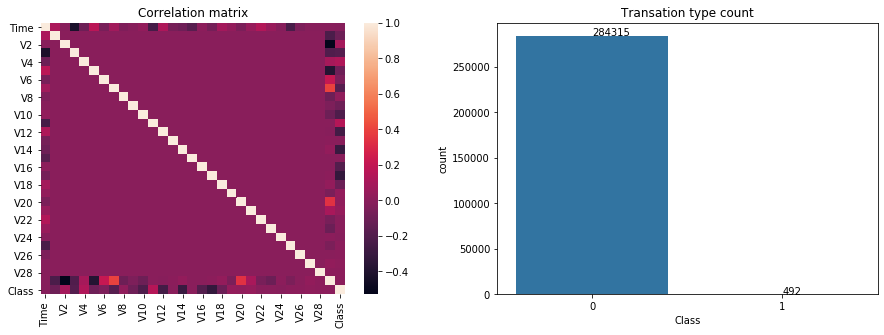

In [4]:
f, ax = plt.subplots(nrows=1 , ncols=2 ,figsize=(15,5))

sns.countplot(data["Class"], ax=ax[1])
ax[1].annotate(len(data[data["Class"]==1]),(1,len(data[data["Class"]==1])))
ax[1].annotate(len(data[data["Class"]==0]),(0,len(data[data["Class"]==0])))
sns.heatmap(data.corr(), ax=ax[0])

ax[1].set_title("Transation type count")
ax[0].set_title("Correlation matrix")

plt.show()

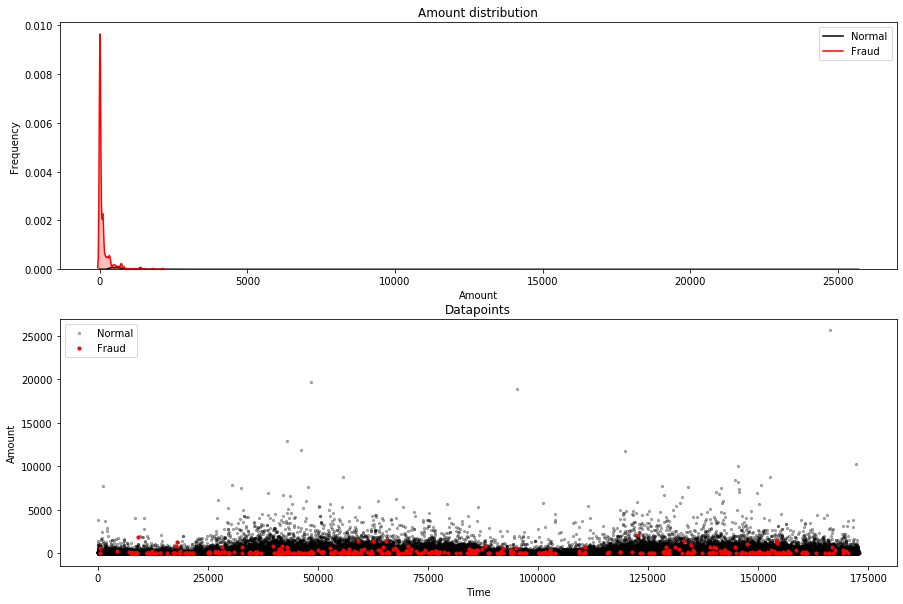

In [5]:
f, ax = plt.subplots(nrows = 2,figsize=(15,10))

sns.kdeplot(data[data["Class"]==0]["Amount"],shade=True,color='k',label='Normal',ax = ax[0])
sns.kdeplot(data[data["Class"]==1]["Amount"],shade=True,color='r',label='Fraud',ax = ax[0])

ax[0].set_title('Amount distribution')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Amount')

ax[1].scatter(data[data["Class"]==0]["Time"],
            data[data["Class"]==0]["Amount"],
            s=5,alpha=0.3,
            label="Normal",
            c="k")

ax[1].scatter(data[data["Class"]==1]["Time"],
            data[data["Class"]==1]["Amount"],
            s=10,
            label="Fraud",
            c="r")

ax[1].set_xlabel("Time")
ax[1].set_ylabel("Amount")
ax[1].set_title('Datapoints')

plt.legend()
plt.show()

This dataset has high dimentionality, so visualization is a problem. Doing pairplots for every variable isn't functional, so I proced with a t-SNE technique to get a 2D plot of the data. Also, I will take only a subsample of normal class for this viz.

In [157]:
subdata = data.copy()
subdata.iloc[:,1:30] = RobustScaler().fit_transform(subdata.iloc[:,1:30])

tsne = TSNE(n_components=2, random_state = 26)
subsample = pd.concat([subdata[subdata['Class']==0].sample(150000),subdata[subdata['Class']==1]])
data_viz = tsne.fit_transform(subsample.drop('Class',axis=1))

color = ['red' if i == 1 else 'k' for i in subsample['Class']]
size = [10 if i == 1 else 1 for i in subsample['Class']]


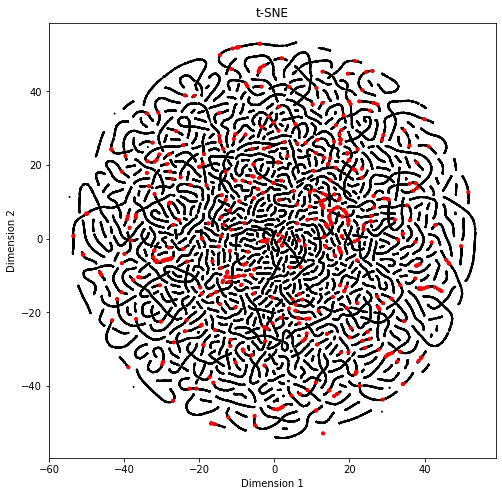

In [158]:
plt.figure(figsize=(8,8))
plt.scatter(pd.DataFrame(data_viz)[0],pd.DataFrame(data_viz)[1], color = color,  s= size)
plt.title('t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

The red dots represent frauds, and there are very close to normal transaction.

# 2. Models

## 2.1 LogisticRegression - Baseline

In [61]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [53]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Class','Time'],axis=1),
                                                    data['Class'],
                                                    test_size = 0.2)

In [152]:
baseline = Pipeline([('scaler',RobustScaler()),
                     ('classifier',LogisticRegression(max_iter = 100000))])

baseline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [153]:
def plot_report(model,X_test,y_test,model_name,figsize):
    
    '''Plots metrics, curves and the classification report'''
    
    f, ax = plt.subplots(nrows = 2, ncols = 2, figsize=figsize)

    '''Confusion matrix'''
    sns.heatmap(confusion_matrix(y_test,model.predict(X_test)), annot = True, 
                cbar = False, ax= ax[0,0],fmt='.2f', cmap = 'RdYlGn')
    
    ax[0,0].set_xlabel('Prediction')
    ax[0,0].set_ylabel('True')
    ax[0,0].set_title('Confusion matrix', fontsize = 15)
    
    
    '''Clasification report'''
    report = classification_report(y_test, model.predict(X_test), output_dict=True)
    sns.heatmap(pd.DataFrame(report).transpose()[['precision', 'recall','f1-score']], 
                annot = True, cbar = False,fmt='.2f', ax = ax[0,1], cmap= 'RdYlGn')
    ax[0,1].set_title('Classification report', fontsize = 15)


    '''PR Curve'''
    plot_precision_recall_curve(model,X_test,y_test,name = model_name, ax = ax[1,0])
    ax[1,0].set_title('Precision-Recall Curve', fontsize = 15)
    
    '''ROC Curve'''
    plot_roc_curve(model,X_test,y_test,name = model_name, ax = ax[1,1])
    ax[1,1].set_title('ROC', fontsize = 15)


    plt.tight_layout()
    plt.show()

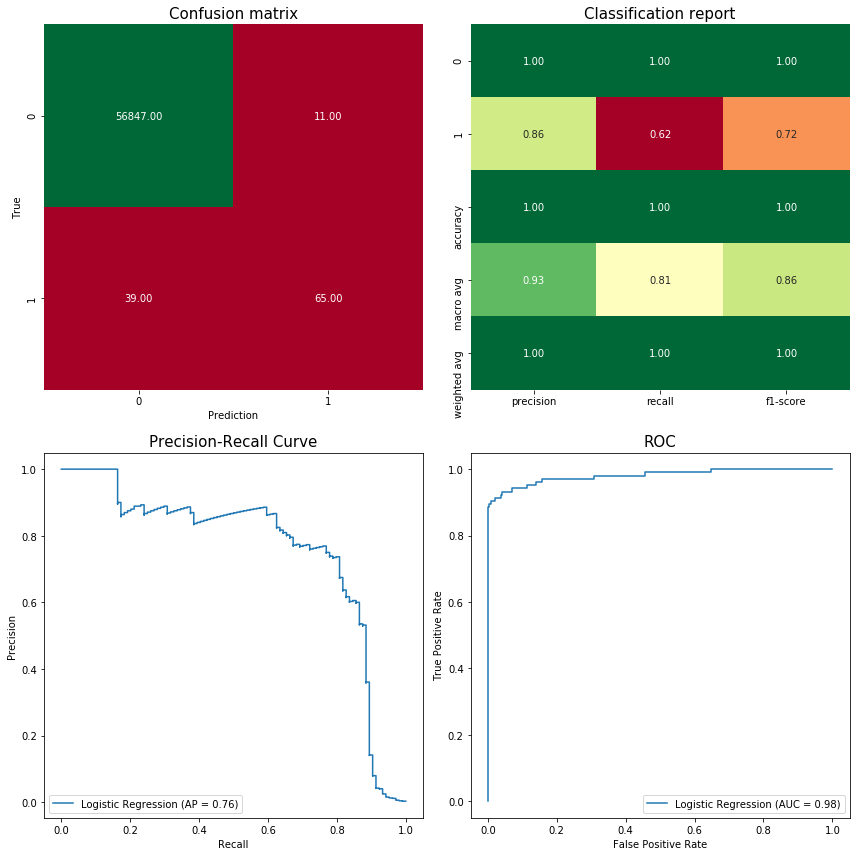

In [154]:
plot_report(baseline,X_test,y_test,'Logistic Regression',(12,12))

## 2.2 Isolation forest

## 2.3 Autoencoder